In [1]:
# ! pip uninstall tensorflow tensorflow-cpu tensorflow-intel tensorflow-directml-plugin keras -y
# ! pip install tensorflow-cpu==2.10 tensorflow-directml-plugin keras
# ! pip uninstall tensorflow tensorflow-cpu tensorflow-intel -y
! pip install numpy==1.23.5
! pip install xgboost
! pip install tensorflow-cpu==2.10
! pip install tensorflow-directml-plugin
! pip install keras
! pip install matplotlib
! pip install opencv-python
! pip install scikit-learn
! pip install pandas
! pip install seaborn
! pip install tqdm




[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import tensorflow as tf


import matplotlib.pyplot as plt
import cv2

from keras.utils import Sequence
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle

import os
import seaborn as sns

print("Numpy Version: ", np.__version__)
print(tf.config.list_physical_devices('GPU'))

Numpy Version:  1.23.5
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


Data Preparation


In [3]:
# split into k-fold cross-val

# verify test_dir is accessible
import numpy as np
import os
import pandas as pd
from PIL import Image
import zipfile


def train_transform(image):
    image = tf.image.resize(image, (224, 224))
    # Apply other transformations (flipping, brightness, etc.)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    # Normalize pixel values to the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image

def test_transform(image):
    image = tf.image.resize(image, (224, 224))
    # Normalize pixel values to the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Normalize the CSV file
def normalize(df):
    # Convert all columns except ID (first) to float64 to prevent dtype issues
    df.iloc[:, 0] = df.iloc[:, 0].astype('int64')
    df.iloc[:, -6:] = df.iloc[:, -6:].astype('float64')

    # Apply log-10 transformation
    df.iloc[:, -6:] = np.log10(df.iloc[:, -6:] + 1e-4)

    # Determine outliers: rows that are more than 3 standard deviations away from the mean
    outlier_mask = (np.abs(df.iloc[:, -6:] - df.iloc[:, -6:].mean()) > (3 * df.iloc[:, -6:].std())).all(axis=1)
    # Retrieve IDs of outlier rows
    outlier_ids = df.loc[outlier_mask, df.columns[0]]
    # Remove outliers (more than 3 standard deviations from the mean)
    df = df[
        ~df[df.columns[0]].isin(outlier_ids)
    ]

    # Normalize the traits
    min_train = df.iloc[:, -6:].min()
    max_train = df.iloc[:, -6:].max()
    df.iloc[:, -6:] = (df.iloc[:, -6:] - min_train) / (max_train - min_train)


    return df, min_train, max_train, outlier_ids    

class ImageDataset(Sequence):
    def __init__(self, img_dir, dataframe=None, transform=None, batch_size=16, shuffle=True, is_train=True, outlier_ids=None):
        self.image_dir = img_dir
        self.img_labels = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
        if outlier_ids is not None:
            self.img_labels = [f for f in self.img_labels if int(f.split('.')[0]) not in outlier_ids]
        self.dataframe = dataframe
        self.transform = transform
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.is_train = is_train
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.img_labels) / self.batch_size))

    def __getitem__(self, idx):
        batch = self.img_labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, ids, features, traits = self.__data_generation(batch)
        return images, ids, features, traits

    def on_epoch_end(self):
        if self.shuffle:
            self.img_labels = shuffle(self.img_labels)

    def __data_generation(self, batch):
        images = []
        ids = []
        features = []
        traits = []
        missing_features = False
        for img_name in batch:
            id = int(img_name.split('.')[0])
            img_path = os.path.join(self.image_dir, img_name)
            image = Image.open(img_path).convert('RGB')

            # convert PIL image to numpy array
            image = np.array(image)

            if self.transform:
                image = self.transform(image)
            image = np.array(image)

            df_row = self.dataframe[self.dataframe.iloc[:, 0] == id]

            if self.is_train:
                feature = df_row.iloc[:, 1:-6].values.astype('float32').flatten()
                if (len(feature) == 0):
                    print("No features found for ID: ", id)
                    missing_features = True
                    continue
                trait = df_row.iloc[:, -6:].values.astype('float32').flatten()
                features.append(feature)
                traits.append(trait)

            else:
                feature = df_row.iloc[:, 1:].values.astype('float32').flatten()
                features.append(feature)

            images.append(image)
            ids.append(id)
        if missing_features:
            print("Missing features for some images. Please check the dataset. ids in batch: ", ids)

        images = np.array(images)
        features = np.array(features)
        traits = np.array(traits)

        return images, ids, features, traits

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')


print(f"Number of training samples before normalization: {len(train_df)}")
train_df, min_train, max_train, outlier_ids = normalize(train_df)
print(f"Number of training samples after normalization: {len(train_df)}")

train_dataset = ImageDataset('data/images/train_images', train_df, train_transform, batch_size=16, shuffle=True, is_train=True, outlier_ids=outlier_ids)
test_dataset = ImageDataset('data/images/test_images', test_df, test_transform, batch_size=16, shuffle=False, is_train=False)

# ensure est_dataset has the same number of samples (6391) as the test_df
print("TEST_SAMPLES: ", len(test_df))
print("TEST_DATASET_SAMPLES: ", len(test_dataset))




Number of training samples before normalization: 43363
Number of training samples after normalization: 43363
TEST_SAMPLES:  6391
TEST_DATASET_SAMPLES:  400


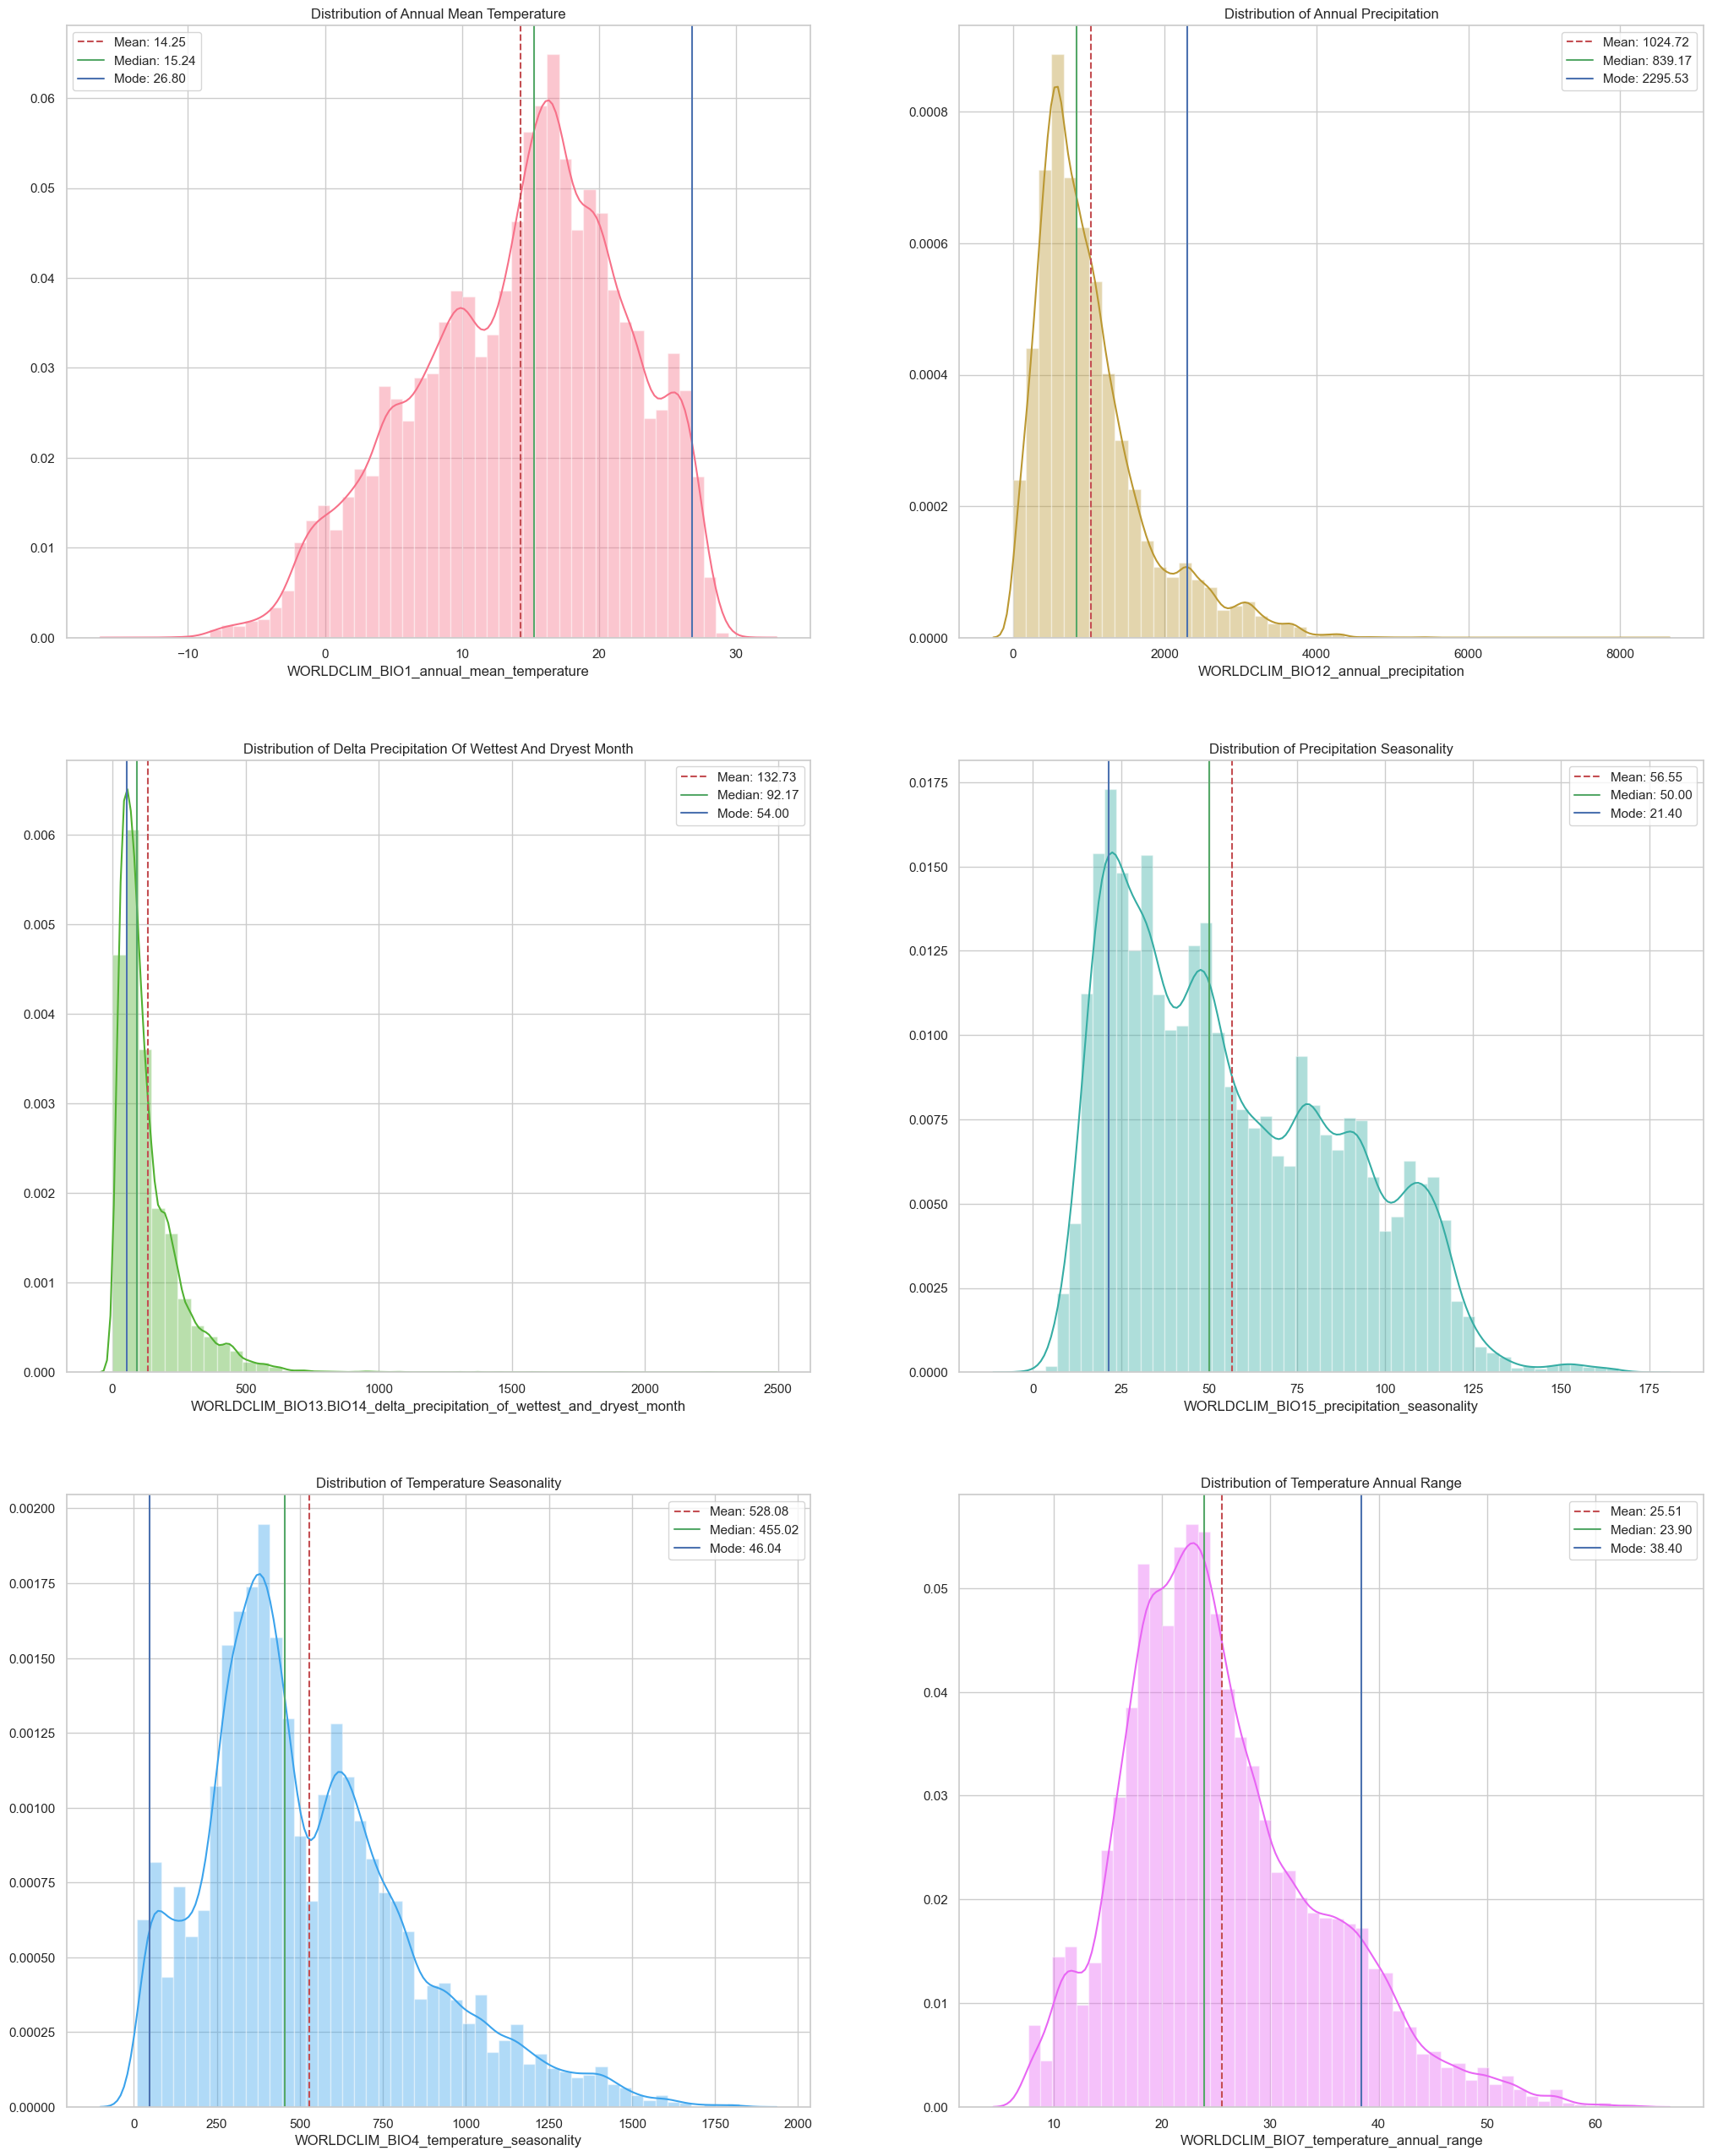

ID,Trait
X4,Stem specific density (SSD) or wood density (stem dry mass per stem fresh volume)
X11,"Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA)"
X18,Plant height
X26,Seed dry mass
X50,Leaf nitrogen (N) content per leaf area
X3112,"Leaf area (in case of compound leaves: leaf, undefined if petiole in- or excluded)"


In [4]:
# https://www.kaggle.com/code/kool777/planttraits-2024-extensive-eda#PlantTraits2024---FGVC11# format column name to generate title
def extract_title(col_name):
    col_name = col_name.replace("WORLDCLIM_", "")
    parts = col_name.split('_')
    meaningful_parts = [part.capitalize() for part in parts if part.isalpha()]
    title = ' '.join(meaningful_parts)
    return title

# function to extract title for soil trait column
def extract_title_soil(col_name):
    parts = col_name.split('_')
    
    top_depth = parts[2].split('.')[0]
    bottom_depth = parts[2].split('.')[1].split('cm')[0]
    
    col_name_array = [part.capitalize() for part in parts if part.isalpha()]
    title = ' '.join(col_name_array)
    
    title_with_depth = f"{title} ({top_depth}-{bottom_depth} cm)"
    return title_with_depth

# calculates mean, median and mode for a dataframe column
def calculate_column_statistics(data, column):
    mean = np.mean(data[column])
    median = np.median(data[column])
    mode = data[column].mode()[0]
    return {'mean': mean, 'median': median, 'mode': mode}

# get pattern from dataframe column
def extract_column_patterns(dataframe, pattern):
    patterns = re.findall(pattern, ' '.join(dataframe.columns))
    patterns_array = list(dict.fromkeys(patterns))
    return patterns_array

# function to plot distribution for each column
def plot_column_distributions(data, columns, statistics, extract_title_func, figsize=(25, 32)):
    num_plots = len(columns)
    ncols = 2
    nrows = (num_plots + ncols - 1) // ncols

    if num_plots < ncols:
        ncols = num_plots
        nrows = 1
    
    f = plt.figure(figsize=figsize)
    gs = f.add_gridspec(nrows, ncols)
    colors = sns.color_palette("husl", len(columns))

    for col, (i, j), color in zip(columns, [(i, j) for i in range(nrows) for j in range(ncols)], colors):
        ax = f.add_subplot(gs[i, j])
        sns.distplot(data[col], ax=ax, kde=True, color=color)
        ax.axvline(statistics[col]['mean'], color='r', linestyle='--', label=f'Mean: {statistics[col]["mean"]:.2f}')
        ax.axvline(statistics[col]['median'], color='g', linestyle='-', label=f'Median: {statistics[col]["median"]:.2f}')
        ax.axvline(statistics[col]['mode'], color='b', linestyle='-', label=f'Mode: {statistics[col]["mode"]:.2f}')
        ax.legend()
        ax.set_title(f"Distribution of {extract_title_func(col)}")
        ax.set_xlabel(col)
        ax.set_ylabel("")

    plt.show()

    # import packages
import os
import re
import textwrap
import warnings
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")


worldclim_columns = [col for col in train_df.columns if col.startswith("WORLDCLIM_BIO")]

statistics = {}
for col in worldclim_columns:
    statistics[col] = calculate_column_statistics(train_df, col)

plot_column_distributions(train_df, worldclim_columns, statistics, extract_title, figsize=(25, 32))



target_name_df = pd.read_csv(os.path.join("data", 'target_name_meta.tsv'), sep='\t', names=["ID", "Trait"], header=0)
target_name_df.style.hide(axis="index").set_table_styles([
    {'selector': 'td', 'props': 'text-align: center; font-weight: bold;'},
])



VGG16 Model -> Feature Extractor

In [5]:
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm
N_EPOCHS = 10

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    VGG16_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # Feature Extraction

    for layer in VGG16_model.layers:
        layer.trainable = False

    # VGG16_model.summary()

    def extract_features(model, dataset, is_train=True):
        features_vector = []
        traits_vector = []
        ids_vector = []
        # set to check duplicate IDs
        ids_set = set()
        with tqdm(total=len(dataset), desc="Extracting features", dynamic_ncols=True, leave=True) as pbar:
            for i in range (len(dataset)):
                images, ids, features, traits = dataset[i]
                # check for duplicate IDs
                for id in ids:
                    if id in ids_set:
                        print(f"Duplicate ID found: {id}")
                    ids_set.add(id)
                    
                if is_train:
                    traits_vector.append(traits)
                
                ids_vector.append(ids)
                extracted_features = model.predict(images, verbose=0)
                extracted_features = extracted_features.reshape(extracted_features.shape[0], -1)

                feature_vec = np.concatenate([extracted_features, features], axis=1)

                # print("SHAPE: ", feature_vec.shape)
                for fv in feature_vec:
                    features_vector.append(fv)
                    
                pbar.update(1)

        # Flatten the features and concatenate batches
        features_vector = np.array(features_vector)
        ids = np.concatenate(ids_vector, axis=0)
        if is_train:
            traits_vector = np.concatenate(traits_vector, axis=0)

        return ids, features_vector, traits_vector

    # check if train_features.npy and train_traits.npy exist
    if os.path.exists('train_features.npy') and os.path.exists('train_traits.npy'):
        print("Loading train_features.npy and train_traits.npy")
        train_features = np.load('train_features.npy')
        train_traits = np.load('train_traits.npy')
    else:
        print("Extracting features from train data")
        # Extract features from train data
        _, train_features, train_traits = extract_features(VGG16_model, train_dataset)
        # save train_features and train_traits
        np.save('train_features.npy', train_features)
        np.save('train_traits.npy', train_traits)

    if os.path.exists('test_features.npy'):
        print("Loading test_features.npy")
        test_features = np.load('test_features.npy')
    else:
        print("Extracting features from test data")
        test_ids, test_features, _ = extract_features(VGG16_model, test_dataset, is_train=False)
        # save test_features
        np.save('test_features.npy', test_features)
        np.save('test_ids.npy', test_ids)


    # Extract features and traits from train_{features,traits}.npy


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Loading train_features.npy and train_traits.npy
Loading test_features.npy


Training XGBoost for trait:  0


Epochs: 100%|██████████| 5/5 [03:50<00:00, 46.02s/it]


Training XGBoost for trait:  1


Epochs: 100%|██████████| 5/5 [06:23<00:00, 76.79s/it]


Training XGBoost for trait:  2


Epochs: 100%|██████████| 5/5 [05:37<00:00, 67.56s/it]


Training XGBoost for trait:  3


Epochs: 100%|██████████| 5/5 [04:09<00:00, 49.97s/it]


Training XGBoost for trait:  4


Epochs: 100%|██████████| 5/5 [06:34<00:00, 78.81s/it]


Training XGBoost for trait:  5


Epochs: 100%|██████████| 5/5 [05:09<00:00, 61.86s/it]


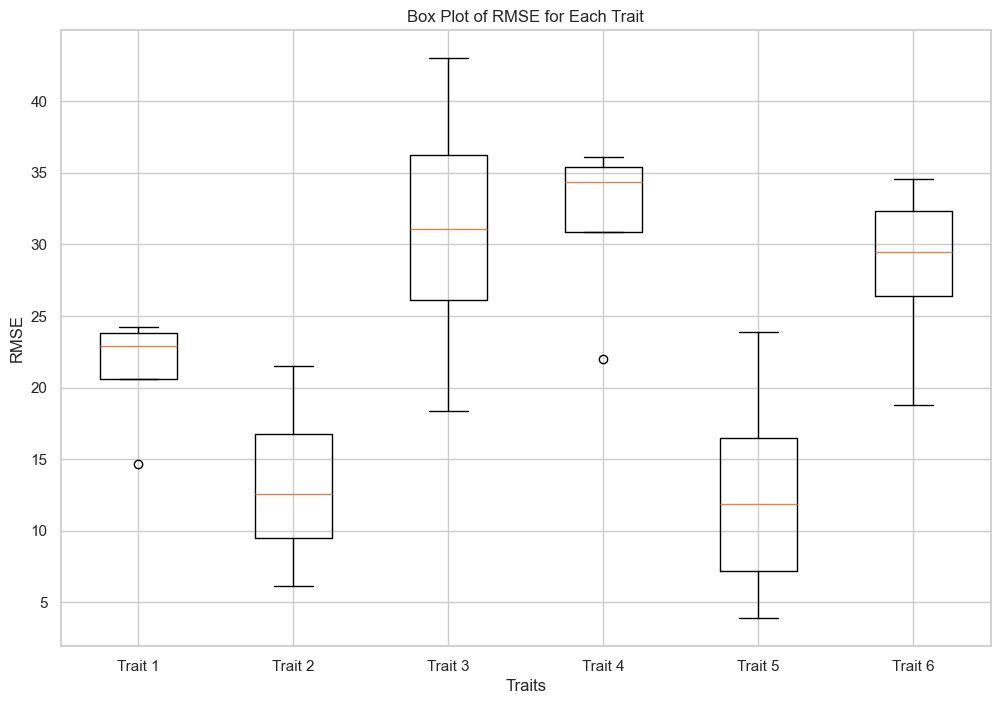

In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error as rmse
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

def train_xgboost_incremental(X_train, y_train, X_test, y_test, trait, batch_size=128, num_epochs=10):
    print("Training XGBoost for trait: ", trait)
    num_samples = X_train.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size  # Calculate the number of batches
    model = None
    rmse_values = []
    dtest = xgb.DMatrix(X_test)
    for epoch in tqdm(range(5), desc=f"Epochs", dynamic_ncols=True):
        for batch_num in tqdm(range(num_batches), desc=f"Training XGBoost for trait {trait}", dynamic_ncols=True):
            batch_start = batch_num * batch_size
            batch_end = min((batch_num + 1) * batch_size, num_samples)
            
            # Explicitly create copies of the sliced data
            X_batch = X_train[batch_start:batch_end].copy()
            y_batch = y_train[batch_start:batch_end].copy()
            
            dtrain = xgb.DMatrix(X_batch, label=y_batch)
            evals_result = {}

            if model is None:
                # Initial training
                model = xgb.train({
                    'objective': 'reg:squarederror',
                    'eval_metric': 'rmse',
                    'eta': 0.1,
                    'tree_method': 'gpu_hist'
                }, dtrain, num_epochs, evals=[(dtrain, 'train')], evals_result=evals_result, verbose_eval=False)
            else:
                # Continue training from the previous model
                model = xgb.train({}, dtrain, num_epochs, xgb_model=model, evals=[(dtrain, 'train')],
                                evals_result=evals_result, verbose_eval=False)
            
            # Save the model after each batch
        model.save_model(f'boost_models/xgboost_{trait}_epoch_{epoch}.model')
            
        # Calculate RMSE for the current batch
        preds = model.predict(dtest)
        rmse_batch = rmse(y_test, preds)
        rmse_values.append(rmse_batch)

    return rmse_values

NUM_TRAITS = 6
BATCH_SIZE = 512
NUM_EPOCHS = 10

X = np.load('train_features.npy').astype(np.float32)
y = np.load('train_traits.npy').astype(np.float32)

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

rmse_per_trait = []
for i in range(NUM_TRAITS):
    rmse_values = train_xgboost_incremental(X_train, y_train[:, i], X_test, y_test[:, i], trait=i, 
                                             batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS)
    rmse_per_trait.append(rmse_values)

# Create box plots for RMSE for each trait
plt.figure(figsize=(12, 8))
plt.boxplot(rmse_per_trait, labels=[f'Trait {i+1}' for i in range(NUM_TRAITS)])
plt.xlabel('Traits')
plt.ylabel('RMSE')
plt.title('Box Plot of RMSE for Each Trait')
plt.show()


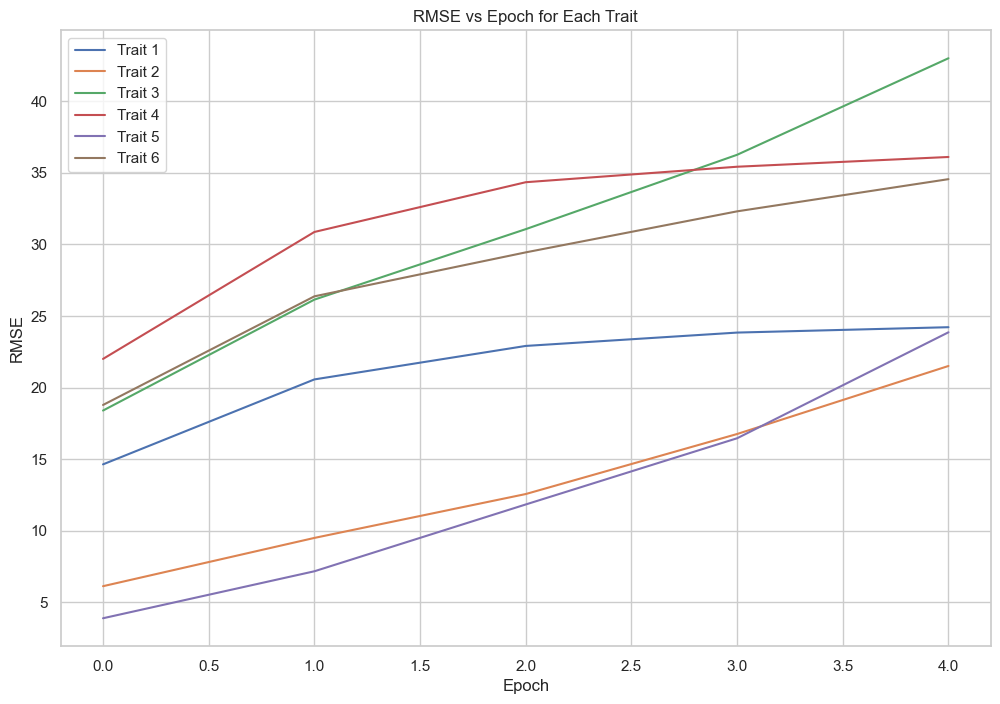

In [9]:
# plot epoch vs RMSE
plt.figure(figsize=(12, 8))
for i in range(NUM_TRAITS):
    plt.plot(range(5), rmse_per_trait[i], label=f'Trait {i+1}')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE vs Epoch for Each Trait')
plt.legend()
plt.show()


In [ ]:
# import xgboost as xgb
# import numpy as np
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import KFold
# from tqdm.auto import tqdm
# import joblib

# NUM_TRAITS = 6
# FOLDS = 3
# BATCH_SIZE = 512
# kf = KFold(n_splits=FOLDS, shuffle=True)

# train_features = np.load('train_features.npy').astype(np.float32)
# train_traits = np.load('train_traits.npy').astype(np.float32)

# print("Train features shape:", train_features.shape)
# print("Train traits shape:", train_traits.shape)

# best_mse = np.inf
# best_model = None
# mse_scores = []

# # Initialize a model dictionary to hold models for each target trait
# rmse_log = {i: [] for i in range(NUM_TRAITS)}  # Dictionary to store RMSE for each trait

# for fold, (train_index, val_index) in enumerate(kf.split(train_features)):
#     if fold != 0:
#         continue
#     print(f"Starting Fold {fold + 1}")
#     models = {}

#     for i in range(NUM_TRAITS):
#         if i not in models:
#             models[i] = None

#     num_batches = (len(train_index) + BATCH_SIZE - 1) // BATCH_SIZE  # Calculate the number of batches

#     # Incrementally train models using batch processing
#     for batch_num in tqdm(range(0, num_batches), desc="Training", dynamic_ncols=True):
#         batch_start = batch_num * BATCH_SIZE
#         batch_end = min((batch_num + 1) * BATCH_SIZE, len(train_index))

#         X_batch = train_features[train_index[batch_start:batch_end]].copy()
#         for i in range(NUM_TRAITS):
#             y_batch = train_traits[train_index[batch_start:batch_end], i].copy()
#             dtrain = xgb.DMatrix(X_batch, label=y_batch)
#             evals_result = {}

#             # Set initial booster model if it hasn't been trained yet
#             if i not in models:
#                 params = {
#                     'objective': 'reg:squarederror',
#                     'eval_metric': 'rmse',
#                     'max_depth': 3,
#                     'learning_rate': 0.01,
#                     'subsample': 0.8,
#                     'tree_method': 'gpu_hist'
#                 }
#                 models[i] = xgb.train(params, dtrain, num_boost_round=10, evals=[(dtrain, 'train')],
#                                       evals_result=evals_result, verbose_eval=True)
#             else:
#                 models[i] = xgb.train({}, dtrain, xgb_model=models[i], num_boost_round=10, evals=[(dtrain, 'train')],
#                                       evals_result=evals_result, verbose_eval=True)
            
#             # Log RMSE for each batch
#             rmse_log[i].extend(evals_result['train']['rmse'])

#         # break        
    
#     print(f"Finished training models for fold {fold + 1}, evaluating on validation set")

#     # Evaluate on the validation set
#     val_preds = []
#     trait_vals = []
#     for batch_num in tqdm(range(0, num_batches), desc="Validating", dynamic_ncols=True):
#         batch_start = batch_num * BATCH_SIZE
#         batch_end = min((batch_num + 1) * BATCH_SIZE, len(val_index))

#         X_val, y_val = train_features[val_index[batch_start:batch_end]].copy(), train_traits[val_index[batch_start:batch_end]].copy()
#         batch_preds = []
#         for i in range(NUM_TRAITS):
#             dval = xgb.DMatrix(X_val)
#             batch_preds.append(models[i].predict(dval))
#         val_preds.append(np.stack(batch_preds, axis=-1))
#         trait_vals.append(y_val)

#     val_preds = np.concatenate(val_preds, axis=0)
#     trait_vals = np.concatenate(trait_vals, axis=0)

#     # Calculate the mean squared error on the validation set
#     print(f"trait_vals shape: {trait_vals.shape}, val_preds shape: {val_preds.shape}")
#     mse = mean_squared_error(trait_vals, val_preds)
    
#     for i in range(len(models)):
#         models[i].save_model(f'data/best_models/xgb_fold_{fold + 1}_trait_{i}.model')
#         joblib.dump(models[i], f'data/best_models/xgb_fold_{fold + 1}_trait_{i}.pkl')

#     print(f"Fold {fold + 1} MSE: {mse}")
#     mse_scores.append(mse)
#     #  save MSE scores for each fold
#     # np.save(f'data/mse_scores/xgb_mse_scores_{fold}.npy', mse_scores)


# plt.figure(figsize=(12, 8))
# for i in range(NUM_TRAITS):
#     plt.plot(rmse_log[i], label=f'Trait {i + 1}')
# plt.xlabel('Boosting Rounds')
# plt.ylabel('RMSE')
# plt.title('RMSE Over Boosting Rounds')
# plt.legend()
# plt.show()



# # Average MSE across folds
# print(f"Average MSE: {np.mean(mse_scores)}")


In [10]:

# Load the test features and ids (already combined with CSV data)
test_features = np.load('test_features.npy')
test_ids = np.load('test_ids.npy')

print("NUM_TEST_SAMPLES: ", len(test_ids))
# Load the pre-trained XGBoost model
models = {}
USE_EPOCH = 4
for i in range(NUM_TRAITS):
    models[i] = xgb.Booster()
    models[i].load_model(f'boost_models/xgboost_{i}_epoch_{USE_EPOCH}.model')

# Predict the trait values using the XGBoost model
test_predictions = []

dtest = xgb.DMatrix(test_features)
for i in range(NUM_TRAITS):
    test_predictions.append(models[i].predict(dtest))


#  want each column to be a trait
test_predictions = np.stack(test_predictions, axis=-1)
# Renormalize the predictions to the original scale

print("test_predictions shape: ", test_predictions.shape)
# min_train and max_train were calculated during normalization, and is a list of the minimum and maximum values for each trait
for i in range(NUM_TRAITS):
    test_predictions[:, i] = (test_predictions[:, i] * (max_train[i] - min_train[i])) + min_train[i]



# Undo the log10 transformation
test_predictions = 10**test_predictions

# Save the predictions to a CSV file with appropriate formatting
# Assuming IDs were part of the test_features (if not, include them in the correct order)
results = np.column_stack((test_ids, test_predictions))

# Define the header
header = "id,X4,X11,X18,X26,X50,X3112"

# Save the results
np.savetxt('submission.csv', results, delimiter=',', header=header, comments='', fmt='%d,' + ','.join(['%.6f'] * 6))

print("Predictions saved to submission.csv")


NUM_TEST_SAMPLES:  6391
test_predictions shape:  (6391, 6)
Predictions saved to submission.csv
